In [ ]:
import cupy as cp
import numpy as np
import pandas as pd
from scipy.linalg import sqrtm
from scipy.optimize import minimize
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import logging
import sys
import os

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(message)s', handlers=[logging.StreamHandler(sys.stdout)])
logger = logging.getLogger(__name__)
# Force log output to be flushed
sys.stdout.flush()

In [ ]:
# === Softmax ===
def softmax(W, X):
    logits = X @ W
    logits -= cp.max(logits, axis=1, keepdims=True)
    exp_logits = cp.exp(logits)
    return exp_logits / cp.sum(exp_logits, axis=1, keepdims=True)

# === Matrix square root ===
def real_sqrtm(M):
    return sqrtm(M.get() + 1e-6 * np.eye(M.shape[0])).real 

# === Scatter matrices ===
def compute_scatter_matrices(X, y):
    n_features = X.shape[1]
    classes = cp.unique(y)
    overall_mean = cp.mean(X, axis=0)
    Sb = cp.zeros((n_features, n_features))
    Sw = cp.zeros((n_features, n_features))
    for c in classes:
        X_c = X[y == c]
        mean_c = cp.mean(X_c, axis=0)
        n_c = X_c.shape[0]
        Sb += n_c * cp.outer(mean_c - overall_mean, mean_c - overall_mean)
        Sw += (X_c - mean_c).T @ (X_c - mean_c)
    return Sb, Sw

In [5]:
# === S2FS ===
def S2FS(X, y, alpha, lambda_, max_iter=100, tol=1e-4, print_interval=25):
    n_samples, n_features = X.shape
    n_classes = len(cp.unique(y))
    Y = cp.eye(n_classes)[cp.asnumpy(y)].astype(cp.float32)

    Sb, Sw = compute_scatter_matrices(X, y)
    Sb_sqrt = cp.asarray(real_sqrtm(Sb))
    inv_Sb_sqrt = cp.linalg.pinv(Sb_sqrt)

    W = cp.random.randn(n_features, n_classes, dtype=cp.float32)
    M = cp.zeros((n_features, n_classes), dtype=cp.float32)
    O = W.copy()
    Lambda1 = cp.zeros((n_features, n_classes), dtype=cp.float32)
    Lambda2 = cp.zeros((n_features, n_classes), dtype=cp.float32)

    mu = cp.float32(1.0)
    rho = cp.float32(1.1)

    for t in range(max_iter):
        # Update W via GPI
        A = inv_Sb_sqrt @ (cp.eye(n_features, dtype=cp.float32) + (alpha / mu) * Sw) @ inv_Sb_sqrt
        B = inv_Sb_sqrt @ (M + O - (Lambda1 + Lambda2) / mu)
        Q, _ = cp.linalg.qr(cp.random.randn(n_features, n_classes, dtype=cp.float32))
        for _ in range(10):
            tau = 1 / (2 * cp.linalg.norm(A, 2))
            T = 2 * (cp.eye(n_features, dtype=cp.float32) - tau * A) @ Q + B
            U, _, Vt = cp.linalg.svd(T, full_matrices=False)
            Q = U @ Vt
        W_new = Sb_sqrt @ Q

        # M update
        threshold = cp.sqrt(2 * lambda_ / mu)
        M_temp = W_new - Lambda1 / mu
        row_norms = cp.linalg.norm(M_temp, axis=1)
        M_new = cp.where(row_norms[:, None] > threshold, M_temp, 0)

        # O update
        def loss_and_grad(O_vec):
            O_mat = cp.asarray(O_vec.reshape(n_features, n_classes), dtype=cp.float32)
            probs = softmax(O_mat, X)
            loss = -cp.sum(Y * cp.log(probs + 1e-12)) / n_samples
            loss += (mu / 2) * cp.linalg.norm(O_mat - (W_new - Lambda2 / mu))**2
            grad = X.T @ (probs - Y) / n_samples + mu * (O_mat - (W_new - Lambda2 / mu))
            return float(loss.get()), cp.asnumpy(grad.ravel())

        res = minimize(loss_and_grad, cp.asnumpy(O.ravel()), method='L-BFGS-B', jac=True)
        O_new = cp.asarray(res.x.reshape(n_features, n_classes))

        if cp.linalg.norm(W_new - M_new) < tol and cp.linalg.norm(W_new - O_new) < tol:
            print(f"Converged at iteration {t}")
            logger.info(f"Converged at iteration {t}")
            break

        Lambda1 += mu * (W_new - M_new)
        Lambda2 += mu * (W_new - O_new)
        mu *= rho
        W, M, O = W_new, M_new, O_new

        # Print number of selected features every 'print_interval' iterations
        if (t + 1) % print_interval == 0:
            feature_scores = cp.linalg.norm(W, axis=1)
            selected = feature_scores > cp.sqrt(2 * lambda_ / mu)
            n_selected_features = cp.sum(selected)
            print(f"Iteration {t + 1}: Number of selected features = {n_selected_features}")
            logger.info(f"Iteration {t + 1}: Number of selected features = {n_selected_features}")

    return W, mu

In [ ]:
# === Load dataset ===
def load_lungs_dataset(file_path='/kaggle/input/lungs-csv/Lung.csv'):

    # Preliminary check: Attempt to read the file with minimal processing
    logger.info(f"Checking file existence and initial read from {file_path}")
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found at {file_path}")
    with open(file_path, 'r') as f:
        first_line = f.readline()
    logger.info(f"First line of file: {first_line.strip()}")

    # Load the full CSV
    logger.info(f"Attempting to load CSV from {file_path}")
    df = pd.read_csv(file_path, header=None)
    
    # Debug: Print detailed CSV information
    logger.info(f"Raw CSV shape: {df.shape}")
    logger.info(f"First 5 rows:\n{df.head()}")
    logger.info(f"Last 5 rows:\n{df.tail()}")
    logger.info(f"Column count: {df.shape[1]}")
    logger.info(f"Sample data from columns (index, first, second-to-last, last):\n{df.iloc[:, [0, 1, -2, -1]].head()}")
        
    # Log data types of all columns
    logger.info(f"Data types of columns:\n{df.dtypes}")

    # Separate features and labels
    X = feature_cols.values.astype(np.float32)  
    y = df.iloc[:, -1].values                  

    logger.info(f"Extracted X shape: {X.shape}")
    logger.info(f"Extracted y shape: {y.shape}")
    logger.info(f"Unique labels before encoding (NumPy): {np.unique(y)}")

    # Convert to CuPy arrays after validation
    logger.info("Converting to CuPy arrays")
    X = cp.asarray(X)
    y = cp.asarray(y)

    # Encode labels
    y = cp.asarray(LabelEncoder().fit_transform(cp.asnumpy(y))).astype(cp.int32)
    logger.info(f"Encoded labels: {cp.unique(y)}")
    logger.info("Dataset loaded and validated successfully")
    return X, y

In [ ]:
# Set random seed for reproducibility
cp.random.seed(42)

# Load dataset
try:
    X, y = load_lungs_dataset()
    logger.info("Dataset loading completed")
except Exception as e:
    logger.error(f"Dataset loading failed, exiting: {str(e)}")
    exit(1)

# Preprocess data
logger.info("Preprocessing data")
X = cp.asarray(StandardScaler().fit_transform(cp.asnumpy(X)))
y = cp.asarray(LabelEncoder().fit_transform(cp.asnumpy(y)))  # Re-encode in case of string labels

X_train, X_val, y_train, y_val = train_test_split(cp.asnumpy(X), cp.asnumpy(y), test_size=0.3, random_state=42)
X_train, X_val = cp.asarray(X_train), cp.asarray(X_val)
y_train, y_val = cp.asarray(y_train), cp.asarray(y_val)
logger.info(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")

# Grid search
alpha_list = [10**i for i in range(-6, 3)]
lambda_list = [10**i for i in range(-6, -1)]

best_acc = 0
best_params = None
best_W = None
best_mu = None

for alpha in alpha_list:
    for lambda_ in lambda_list:
        print(f"Training with α={alpha}, λ={lambda_}")
        logger.info(f"Training with α={alpha}, λ={lambda_}")
        W, mu_final = S2FS(X_train, y_train, alpha, lambda_, max_iter=100)

        feature_scores = cp.linalg.norm(W, axis=1)
        selected = cp.argsort(feature_scores)[::-1][:int(0.1 * X.shape[1])]
        clf = KNeighborsClassifier(n_neighbors=5)
        clf.fit(cp.asnumpy(X_train[:, selected]), cp.asnumpy(y_train))
        acc = clf.score(cp.asnumpy(X_val[:, selected]), cp.asnumpy(y_val))
        print(f"Validation Accuracy: {acc:.4f}")
        logger.info(f"Validation Accuracy: {acc:.4f}")

        if acc > best_acc:
            best_acc = acc
            best_params = (alpha, lambda_)
            best_W = W
            best_mu = mu_final

# Final reporting
final_threshold = cp.sqrt(2 * best_params[1] / best_mu)
final_scores = cp.linalg.norm(best_W, axis=1)
selected_features = final_scores > final_threshold
n_selected = cp.sum(selected_features)

print("\nBest Hyperparameters:")
print(f"Alpha = {best_params[0]}, Lambda = {best_params[1]}")
print(f"Best Validation Accuracy: {best_acc:.4f}")
print(f"Number of Selected Features (||w_i|| > √(2λ/μ)): {n_selected}")
logger.info(f"Best Hyperparameters: Alpha = {best_params[0]}, Lambda = {best_params[1]}")
logger.info(f"Best Validation Accuracy: {best_acc:.4f}")
logger.info(f"Number of Selected Features (||w_i|| > √(2λ/μ)): {n_selected}")

# Accuracy vs. Feature Ratio Plot
ratios = cp.linspace(0.02, 0.2, 10)
accuracies = []
feature_counts = []
sorted_indices = cp.argsort(final_scores)[::-1]

for r in ratios:
    k = max(1, int(r * X.shape[1]))
    selected = sorted_indices[:k]
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(cp.asnumpy(X_train[:, selected]), cp.asnumpy(y_train))
    acc = clf.score(cp.asnumpy(X_val[:, selected]), cp.asnumpy(y_val))
    accuracies.append(acc)
    feature_counts.append(k)
    print(f"Ratio: {r:.2f}, Features: {k}, Accuracy: {acc:.4f}")
    logger.info(f"Ratio: {r:.2f}, Features: {k}, Accuracy: {acc:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(feature_counts, accuracies, marker='o')
plt.title("Accuracy vs. Number of Selected Features (S2FS on Lungs Dataset)")
plt.xlabel("Number of Features")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.tight_layout()
plt.savefig('s2fs_accuracy_plot.png')
plt.show()
logger.info("Plot saved as 's2fs_accuracy_plot.png'")

Training with α=1e-06, λ=1e-06
Iteration 25: Number of selected features = 0
Iteration 50: Number of selected features = 607
Iteration 75: Number of selected features = 2595
Iteration 100: Number of selected features = 3305
Validation Accuracy: 0.9180
Training with α=1e-06, λ=1e-05
Iteration 25: Number of selected features = 1
Iteration 50: Number of selected features = 1
Iteration 75: Number of selected features = 497
Iteration 100: Number of selected features = 3082
Validation Accuracy: 0.9180
Training with α=1e-06, λ=0.0001
Iteration 25: Number of selected features = 0
Iteration 50: Number of selected features = 0
Iteration 75: Number of selected features = 4
Iteration 100: Number of selected features = 380
Validation Accuracy: 0.9016
Training with α=1e-06, λ=0.001
Iteration 25: Number of selected features = 0
Iteration 50: Number of selected features = 0
Iteration 75: Number of selected features = 0
Iteration 100: Number of selected features = 12
Validation Accuracy: 0.9180
Trainin

In [ ]:
# Set random seed for reproducibility
cp.random.seed(42)

# Load dataset
X, y = load_lungs_dataset()
logger.info("Dataset loading completed")

# Preprocess data
logger.info("Preprocessing data")
X = cp.asarray(StandardScaler().fit_transform(cp.asnumpy(X)))
y = cp.asarray(LabelEncoder().fit_transform(cp.asnumpy(y)))

X_train, X_val, y_train, y_val = train_test_split(cp.asnumpy(X), cp.asnumpy(y), test_size=0.3, random_state=42)
X_train, X_val = cp.asarray(X_train), cp.asarray(X_val)
y_train, y_val = cp.asarray(y_train), cp.asarray(y_val)
logger.info(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")

Training with α=0.1, λ=1e-06
Iteration 25: Number of selected features = 0
Iteration 50: Number of selected features = 412
Iteration 75: Number of selected features = 2592
Iteration 100: Number of selected features = 3306
Validation Accuracy: 0.9180
Training with α=0.1, λ=1e-05
Iteration 25: Number of selected features = 1
Iteration 50: Number of selected features = 1
Iteration 75: Number of selected features = 492
Iteration 100: Number of selected features = 3081
Validation Accuracy: 0.9180
Training with α=0.1, λ=0.0001
Iteration 25: Number of selected features = 0
Iteration 50: Number of selected features = 0
Iteration 75: Number of selected features = 4
Iteration 100: Number of selected features = 444
Validation Accuracy: 0.9180
Training with α=0.1, λ=0.001
Iteration 25: Number of selected features = 0
Iteration 50: Number of selected features = 0
Iteration 75: Number of selected features = 0
Iteration 100: Number of selected features = 14
Validation Accuracy: 0.9344
Training with α

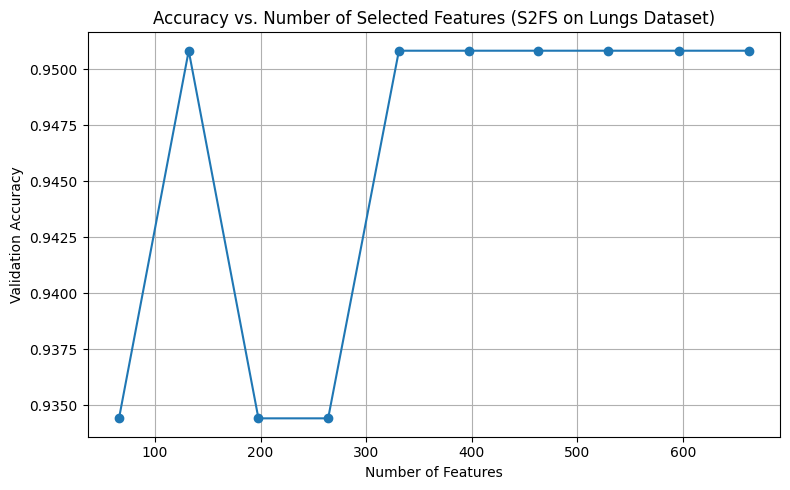

In [10]:
# Grid search
alpha_list = [0.1, 1, 10, 100]
lambda_list = [0.000001, 0.00001, 0.0001, 0.001, 0.01]

best_acc = 0
best_params = None
best_W = None
best_mu = None

for alpha in alpha_list:
    for lambda_ in lambda_list:
        print(f"Training with α={alpha}, λ={lambda_}")
        logger.info(f"Training with α={alpha}, λ={lambda_}")
        W, mu_final = S2FS(X_train, y_train, alpha, lambda_, max_iter=100)

        feature_scores = cp.linalg.norm(W, axis=1)
        selected = cp.argsort(feature_scores)[::-1][:int(0.1 * X.shape[1])]
        clf = KNeighborsClassifier(n_neighbors=5)
        clf.fit(cp.asnumpy(X_train[:, selected]), cp.asnumpy(y_train))
        acc = clf.score(cp.asnumpy(X_val[:, selected]), cp.asnumpy(y_val))
        print(f"Validation Accuracy: {acc:.4f}")
        logger.info(f"Validation Accuracy: {acc:.4f}")

        if acc > best_acc:
            best_acc = acc
            best_params = (alpha, lambda_)
            best_W = W
            best_mu = mu_final

# Final reporting
final_threshold = cp.sqrt(2 * best_params[1] / best_mu)
final_scores = cp.linalg.norm(best_W, axis=1)
selected_features = final_scores > final_threshold
n_selected = cp.sum(selected_features)

print("\nBest Hyperparameters:")
print(f"Alpha = {best_params[0]}, Lambda = {best_params[1]}")
print(f"Best Validation Accuracy: {best_acc:.4f}")
print(f"Number of Selected Features (||w_i|| > √(2λ/μ)): {n_selected}")
logger.info(f"Best Hyperparameters: Alpha = {best_params[0]}, Lambda = {best_params[1]}")
logger.info(f"Best Validation Accuracy: {best_acc:.4f}")
logger.info(f"Number of Selected Features (||w_i|| > √(2λ/μ)): {n_selected}")

# Accuracy vs. Feature Ratio Plot
ratios = cp.linspace(0.02, 0.2, 10)
accuracies = []
feature_counts = []
sorted_indices = cp.argsort(final_scores)[::-1]

for r in ratios:
    k = max(1, int(r * X.shape[1]))
    selected = sorted_indices[:k]
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(cp.asnumpy(X_train[:, selected]), cp.asnumpy(y_train))
    acc = clf.score(cp.asnumpy(X_val[:, selected]), cp.asnumpy(y_val))
    accuracies.append(acc)
    feature_counts.append(k)
    print(f"Ratio: {r:.2f}, Features: {k}, Accuracy: {acc:.4f}")
    logger.info(f"Ratio: {r:.2f}, Features: {k}, Accuracy: {acc:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(feature_counts, accuracies, marker='o')
plt.title("Accuracy vs. Number of Selected Features (S2FS on Lungs Dataset)")
plt.xlabel("Number of Features")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.tight_layout()
plt.savefig('s2fs_accuracy_plot.png')
plt.show()
logger.info("Plot saved as 's2fs_accuracy_plot.png'")